# Want to Build My Own GAN From Scratch with PyTorch

* doesn't seem crazy difficult, generator + discriminator are just simple neural nets
* let's use MNIST as an example
* we can define loss functions for each network; \
L_D = E (x ~ p*) [log D(x)] - E (z ~ pz) [log (1 - D(G(z)))] \
L_G = -E (z ~ pz) [log(D(G(z)))]
* have one larger nn module that houses both, in a forward pass we generate m samples from G + get m samples from p*
* then we run them through D and then compute loss k times (6 optimizer steps?)
* then we tune G once


## Setup

In [1]:
!pip install torch

In [148]:
from torch import nn, optim, accelerator, randn, ones, zeros, no_grad, mean, log
from torchvision.utils import make_grid

In [136]:
device = accelerator.current_accelerator().type if accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [137]:
# hyperparams

epochs = 50
latent_dim = 64
batch_size = 64
lr_g = 0.0002
lr_d = 0.0002
k = 1

In [149]:
def show_grid(images):
    images = images.view(-1, 1, 28, 28)
    images = (images + 1) / 2  # [-1,1] → [0,1]
    grid = make_grid(images, nrow=4)
    plt.figure(figsize=(4,4))
    plt.imshow(grid.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.show()

## Data Loader

In [139]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# IMPORTANT for GANs: transforms should match generator output range
transform = transforms.Compose([
    transforms.ToTensor(),                    # converts (H,W,C) → tensor in [0,1]
    transforms.Normalize((0.5,), (0.5,))      # scale to [-1, 1]
])

dataset = datasets.MNIST(
    root="mnist_data",
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True  # ensures every batch is full-sized
)


## Generator

* so idea is to pass in a latent vector z that's 1x64
* it should return a 1x784 (flattened 28x28 image) after a tanh (to normalize between -1 & 1)


In [140]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            nn.Tanh()
        )
        # need tanh to normalize between (-1, 1)


    def forward(self, x):
        return self.layers(x)

## Discriminator

* takes in an image (1x784) and is just a binary classifier

In [141]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # leaky relu to avoid "dead relu issue" where relu outputs 0 for all negative vals, neurons can be stuck at 0 forever
        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [150]:
G = Generator().to(device)

In [151]:
D = Discriminator().to(device)

In [152]:
G

Generator(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

In [153]:
D

Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Defining Optimizers

In [154]:
loss_fn = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr_d, betas=(0.5, 0.999))

## Training Loop

* so we start by generating m samples from G and sampling m values from our data
* generating m samples from G means using torch.randn

Epoch [1/50] Batch [0/937] D_loss: 1.3761 G_loss: 0.6956 D(real): 0.0325 D(fake): -0.0047
Epoch [1/50] Batch [100/937] D_loss: 1.2201 G_loss: 1.0782 D(real): 0.5030 D(fake): -0.6521
Epoch [1/50] Batch [200/937] D_loss: 1.2710 G_loss: 0.9516 D(real): 0.2393 D(fake): -0.4565
Epoch [1/50] Batch [300/937] D_loss: 1.3153 G_loss: 0.7895 D(real): 0.0043 D(fake): -0.1789
Epoch [1/50] Batch [400/937] D_loss: 1.3079 G_loss: 0.7308 D(real): 0.2113 D(fake): -0.0611
Epoch [1/50] Batch [500/937] D_loss: 1.2608 G_loss: 0.8340 D(real): 0.2741 D(fake): -0.2544
Epoch [1/50] Batch [600/937] D_loss: 1.2518 G_loss: 0.7481 D(real): 0.1103 D(fake): -0.0978
Epoch [1/50] Batch [700/937] D_loss: 1.5315 G_loss: 0.6938 D(real): -0.2892 D(fake): 0.0131
Epoch [1/50] Batch [800/937] D_loss: 1.2951 G_loss: 1.0191 D(real): 0.4872 D(fake): -0.5600
Epoch [1/50] Batch [900/937] D_loss: 1.2941 G_loss: 0.7292 D(real): 0.0579 D(fake): -0.0567

--- Generated samples at epoch 1 ---


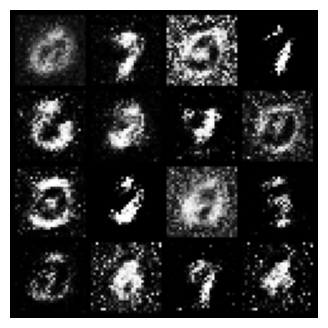

Epoch [2/50] Batch [0/937] D_loss: 1.3509 G_loss: 1.4044 D(real): 1.0444 D(fake): -1.1148
Epoch [2/50] Batch [100/937] D_loss: 1.4842 G_loss: 1.6806 D(real): 1.4822 D(fake): -1.4665
Epoch [2/50] Batch [200/937] D_loss: 1.2433 G_loss: 0.6295 D(real): -0.0336 D(fake): 0.1593
Epoch [2/50] Batch [300/937] D_loss: 1.2360 G_loss: 0.8115 D(real): 0.0934 D(fake): -0.2121
Epoch [2/50] Batch [400/937] D_loss: 1.3484 G_loss: 1.2503 D(real): 1.1013 D(fake): -0.9014
Epoch [2/50] Batch [500/937] D_loss: 1.1825 G_loss: 1.2163 D(real): 0.7205 D(fake): -0.8559
Epoch [2/50] Batch [600/937] D_loss: 1.2551 G_loss: 0.6416 D(real): -0.4006 D(fake): 0.1204
Epoch [2/50] Batch [700/937] D_loss: 1.3581 G_loss: 1.1626 D(real): 0.9727 D(fake): -0.7768
Epoch [2/50] Batch [800/937] D_loss: 1.3040 G_loss: 1.2405 D(real): 0.6116 D(fake): -0.8850
Epoch [2/50] Batch [900/937] D_loss: 1.2517 G_loss: 0.8786 D(real): 0.1518 D(fake): -0.3196

--- Generated samples at epoch 2 ---


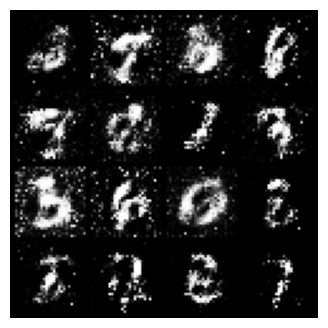

Epoch [3/50] Batch [0/937] D_loss: 1.2388 G_loss: 0.7322 D(real): 0.1667 D(fake): -0.0531
Epoch [3/50] Batch [100/937] D_loss: 1.3170 G_loss: 0.8977 D(real): 0.2442 D(fake): -0.3533
Epoch [3/50] Batch [200/937] D_loss: 1.2033 G_loss: 1.1525 D(real): 0.6331 D(fake): -0.7596
Epoch [3/50] Batch [300/937] D_loss: 1.1832 G_loss: 0.7557 D(real): -0.0270 D(fake): -0.0976
Epoch [3/50] Batch [400/937] D_loss: 1.2409 G_loss: 0.6973 D(real): -0.2065 D(fake): 0.0218
Epoch [3/50] Batch [500/937] D_loss: 1.2241 G_loss: 1.0100 D(real): 0.3542 D(fake): -0.5246
Epoch [3/50] Batch [600/937] D_loss: 1.1504 G_loss: 1.4044 D(real): 0.9132 D(fake): -1.0967
Epoch [3/50] Batch [700/937] D_loss: 1.2205 G_loss: 1.0796 D(real): 0.3870 D(fake): -0.6445
Epoch [3/50] Batch [800/937] D_loss: 1.2527 G_loss: 1.3232 D(real): 1.1803 D(fake): -1.0004
Epoch [3/50] Batch [900/937] D_loss: 1.1492 G_loss: 0.9537 D(real): 0.2923 D(fake): -0.4465

--- Generated samples at epoch 3 ---


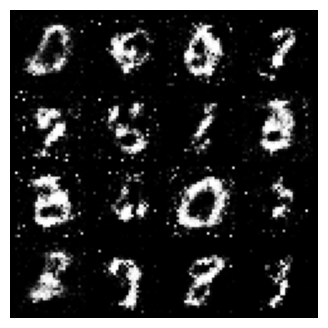

Epoch [4/50] Batch [0/937] D_loss: 1.2218 G_loss: 1.1370 D(real): 0.6113 D(fake): -0.7142
Epoch [4/50] Batch [100/937] D_loss: 1.6819 G_loss: 0.4815 D(real): -1.2122 D(fake): 0.5190
Epoch [4/50] Batch [200/937] D_loss: 1.3499 G_loss: 1.3599 D(real): 0.6760 D(fake): -1.0356
Epoch [4/50] Batch [300/937] D_loss: 1.3914 G_loss: 1.6079 D(real): 0.9820 D(fake): -1.3728
Epoch [4/50] Batch [400/937] D_loss: 1.2764 G_loss: 0.8078 D(real): 0.1379 D(fake): -0.1717
Epoch [4/50] Batch [500/937] D_loss: 1.2634 G_loss: 0.7167 D(real): -0.1290 D(fake): 0.0092
Epoch [4/50] Batch [600/937] D_loss: 1.1982 G_loss: 0.6588 D(real): -0.0271 D(fake): 0.1309
Epoch [4/50] Batch [700/937] D_loss: 1.1639 G_loss: 0.9221 D(real): 0.2255 D(fake): -0.3729
Epoch [4/50] Batch [800/937] D_loss: 1.2838 G_loss: 1.2314 D(real): 0.8942 D(fake): -0.8565
Epoch [4/50] Batch [900/937] D_loss: 1.2350 G_loss: 1.3094 D(real): 0.7744 D(fake): -0.9695

--- Generated samples at epoch 4 ---


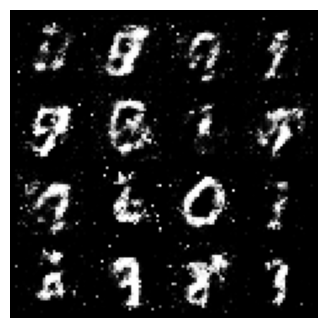

Epoch [5/50] Batch [0/937] D_loss: 1.1873 G_loss: 0.9654 D(real): 0.2932 D(fake): -0.4466
Epoch [5/50] Batch [100/937] D_loss: 1.1563 G_loss: 1.1659 D(real): 0.6135 D(fake): -0.7659
Epoch [5/50] Batch [200/937] D_loss: 1.2886 G_loss: 0.6870 D(real): -0.1767 D(fake): 0.0527
Epoch [5/50] Batch [300/937] D_loss: 1.2055 G_loss: 0.9943 D(real): 0.2238 D(fake): -0.5040
Epoch [5/50] Batch [400/937] D_loss: 1.1682 G_loss: 1.0167 D(real): 0.4474 D(fake): -0.5344
Epoch [5/50] Batch [500/937] D_loss: 1.1919 G_loss: 1.1081 D(real): 0.6294 D(fake): -0.6803
Epoch [5/50] Batch [600/937] D_loss: 1.2642 G_loss: 0.9705 D(real): 0.6613 D(fake): -0.4619
Epoch [5/50] Batch [700/937] D_loss: 1.1716 G_loss: 0.7988 D(real): 0.0234 D(fake): -0.1540
Epoch [5/50] Batch [800/937] D_loss: 1.2207 G_loss: 0.7543 D(real): 0.0888 D(fake): -0.0862
Epoch [5/50] Batch [900/937] D_loss: 1.2008 G_loss: 1.0775 D(real): 0.4905 D(fake): -0.6156

--- Generated samples at epoch 5 ---


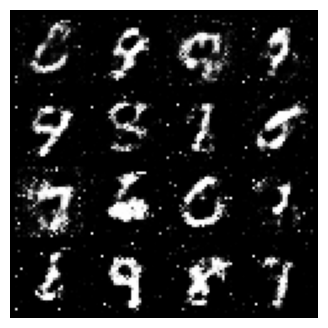

Epoch [6/50] Batch [0/937] D_loss: 1.1995 G_loss: 1.2601 D(real): 0.8022 D(fake): -0.8938
Epoch [6/50] Batch [100/937] D_loss: 1.2264 G_loss: 1.1248 D(real): 0.5901 D(fake): -0.7019
Epoch [6/50] Batch [200/937] D_loss: 1.2352 G_loss: 0.8375 D(real): 0.0527 D(fake): -0.2345
Epoch [6/50] Batch [300/937] D_loss: 1.2599 G_loss: 1.1565 D(real): 0.7334 D(fake): -0.7518
Epoch [6/50] Batch [400/937] D_loss: 1.2740 G_loss: 1.0559 D(real): 0.4594 D(fake): -0.5935
Epoch [6/50] Batch [500/937] D_loss: 1.2225 G_loss: 0.8063 D(real): 0.1310 D(fake): -0.1585
Epoch [6/50] Batch [600/937] D_loss: 1.4394 G_loss: 0.5928 D(real): -0.7593 D(fake): 0.2758
Epoch [6/50] Batch [700/937] D_loss: 1.1677 G_loss: 0.8352 D(real): 0.1476 D(fake): -0.2112
Epoch [6/50] Batch [800/937] D_loss: 1.2148 G_loss: 1.2558 D(real): 0.9723 D(fake): -0.8847
Epoch [6/50] Batch [900/937] D_loss: 1.2401 G_loss: 0.6010 D(real): -0.2314 D(fake): 0.2682

--- Generated samples at epoch 6 ---


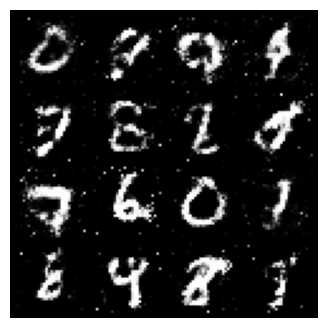

Epoch [7/50] Batch [0/937] D_loss: 1.2228 G_loss: 0.8434 D(real): 0.0074 D(fake): -0.2305
Epoch [7/50] Batch [100/937] D_loss: 1.2051 G_loss: 0.7989 D(real): 0.1963 D(fake): -0.1445
Epoch [7/50] Batch [200/937] D_loss: 1.2751 G_loss: 0.6969 D(real): 0.0877 D(fake): 0.0483
Epoch [7/50] Batch [300/937] D_loss: 1.1377 G_loss: 1.1056 D(real): 0.6221 D(fake): -0.6666
Epoch [7/50] Batch [400/937] D_loss: 1.1596 G_loss: 1.1147 D(real): 0.5839 D(fake): -0.6773
Epoch [7/50] Batch [500/937] D_loss: 1.2314 G_loss: 0.9893 D(real): 0.3028 D(fake): -0.4843
Epoch [7/50] Batch [600/937] D_loss: 1.2229 G_loss: 1.1400 D(real): 0.6938 D(fake): -0.7109
Epoch [7/50] Batch [700/937] D_loss: 1.1625 G_loss: 0.9258 D(real): 0.2537 D(fake): -0.3635
Epoch [7/50] Batch [800/937] D_loss: 1.1967 G_loss: 0.8735 D(real): 0.2247 D(fake): -0.2770
Epoch [7/50] Batch [900/937] D_loss: 1.1546 G_loss: 1.2432 D(real): 0.6427 D(fake): -0.8689

--- Generated samples at epoch 7 ---


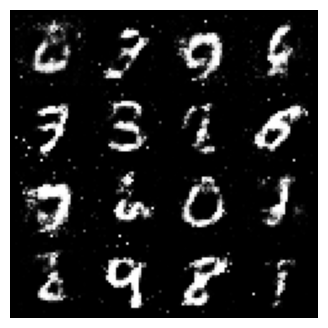

Epoch [8/50] Batch [0/937] D_loss: 1.3935 G_loss: 1.1947 D(real): 0.9664 D(fake): -0.7811
Epoch [8/50] Batch [100/937] D_loss: 1.2267 G_loss: 0.7002 D(real): -0.1025 D(fake): 0.0454
Epoch [8/50] Batch [200/937] D_loss: 1.1968 G_loss: 0.9764 D(real): 0.3970 D(fake): -0.4494
Epoch [8/50] Batch [300/937] D_loss: 1.1740 G_loss: 0.9572 D(real): 0.2781 D(fake): -0.4144
Epoch [8/50] Batch [400/937] D_loss: 1.4185 G_loss: 0.4470 D(real): -0.6347 D(fake): 0.6657
Epoch [8/50] Batch [500/937] D_loss: 1.3098 G_loss: 1.2877 D(real): 0.7659 D(fake): -0.9257
Epoch [8/50] Batch [600/937] D_loss: 1.2473 G_loss: 0.9883 D(real): 0.2451 D(fake): -0.4826
Epoch [8/50] Batch [700/937] D_loss: 1.2237 G_loss: 0.9225 D(real): 0.0607 D(fake): -0.3647
Epoch [8/50] Batch [800/937] D_loss: 1.2159 G_loss: 1.0592 D(real): 0.4960 D(fake): -0.5602
Epoch [8/50] Batch [900/937] D_loss: 1.2212 G_loss: 0.9801 D(real): 0.4533 D(fake): -0.4417

--- Generated samples at epoch 8 ---


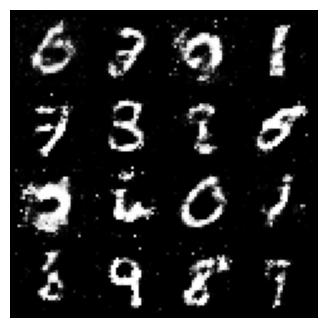

Epoch [9/50] Batch [0/937] D_loss: 1.3647 G_loss: 0.4960 D(real): -0.5244 D(fake): 0.5206
Epoch [9/50] Batch [100/937] D_loss: 1.2259 G_loss: 0.8440 D(real): 0.1615 D(fake): -0.2036
Epoch [9/50] Batch [200/937] D_loss: 1.1930 G_loss: 0.9384 D(real): 0.3710 D(fake): -0.3935
Epoch [9/50] Batch [300/937] D_loss: 1.2365 G_loss: 0.8035 D(real): -0.1421 D(fake): -0.1579
Epoch [9/50] Batch [400/937] D_loss: 1.2668 G_loss: 0.7872 D(real): 0.0986 D(fake): -0.0965
Epoch [9/50] Batch [500/937] D_loss: 1.2055 G_loss: 0.7999 D(real): 0.2241 D(fake): -0.1517
Epoch [9/50] Batch [600/937] D_loss: 1.2477 G_loss: 0.9084 D(real): 0.1897 D(fake): -0.3369
Epoch [9/50] Batch [700/937] D_loss: 1.2240 G_loss: 0.7571 D(real): 0.0869 D(fake): -0.0711
Epoch [9/50] Batch [800/937] D_loss: 1.1760 G_loss: 1.1281 D(real): 0.8044 D(fake): -0.7126
Epoch [9/50] Batch [900/937] D_loss: 1.1499 G_loss: 1.1599 D(real): 0.7996 D(fake): -0.7583

--- Generated samples at epoch 9 ---


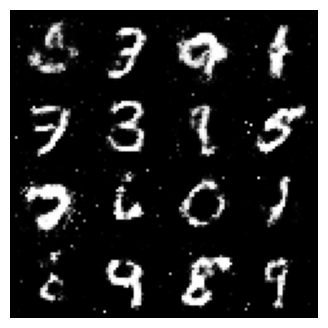

Epoch [10/50] Batch [0/937] D_loss: 1.1467 G_loss: 0.9085 D(real): 0.2395 D(fake): -0.3475
Epoch [10/50] Batch [100/937] D_loss: 1.2280 G_loss: 0.8261 D(real): 0.1845 D(fake): -0.1874
Epoch [10/50] Batch [200/937] D_loss: 1.2317 G_loss: 0.7653 D(real): -0.0074 D(fake): -0.0408
Epoch [10/50] Batch [300/937] D_loss: 1.2204 G_loss: 1.0887 D(real): 0.4907 D(fake): -0.6349
Epoch [10/50] Batch [400/937] D_loss: 1.4540 G_loss: 0.6520 D(real): -0.6188 D(fake): 0.1901
Epoch [10/50] Batch [500/937] D_loss: 1.2629 G_loss: 1.4988 D(real): 0.9184 D(fake): -1.2112
Epoch [10/50] Batch [600/937] D_loss: 1.2038 G_loss: 0.8307 D(real): 0.2586 D(fake): -0.1968
Epoch [10/50] Batch [700/937] D_loss: 1.1819 G_loss: 1.1018 D(real): 0.4541 D(fake): -0.6743
Epoch [10/50] Batch [800/937] D_loss: 1.2109 G_loss: 0.7487 D(real): -0.1341 D(fake): -0.0210
Epoch [10/50] Batch [900/937] D_loss: 1.2483 G_loss: 0.6293 D(real): -0.0696 D(fake): 0.2219

--- Generated samples at epoch 10 ---


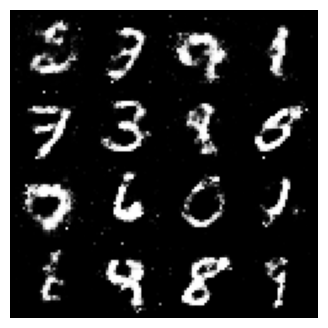

Epoch [11/50] Batch [0/937] D_loss: 1.2398 G_loss: 1.0009 D(real): 0.4853 D(fake): -0.4956
Epoch [11/50] Batch [100/937] D_loss: 1.1458 G_loss: 0.8669 D(real): 0.2556 D(fake): -0.2680
Epoch [11/50] Batch [200/937] D_loss: 1.2623 G_loss: 0.6724 D(real): -0.0123 D(fake): 0.0959
Epoch [11/50] Batch [300/937] D_loss: 1.2277 G_loss: 0.9845 D(real): 0.4946 D(fake): -0.4705
Epoch [11/50] Batch [400/937] D_loss: 1.1747 G_loss: 0.6112 D(real): 0.0202 D(fake): 0.2444
Epoch [11/50] Batch [500/937] D_loss: 1.2360 G_loss: 0.6305 D(real): -0.0695 D(fake): 0.1846
Epoch [11/50] Batch [600/937] D_loss: 1.3219 G_loss: 1.3078 D(real): 1.1693 D(fake): -0.9504
Epoch [11/50] Batch [700/937] D_loss: 1.1936 G_loss: 1.0530 D(real): 0.5377 D(fake): -0.5906
Epoch [11/50] Batch [800/937] D_loss: 1.2503 G_loss: 1.0987 D(real): 0.7710 D(fake): -0.6587
Epoch [11/50] Batch [900/937] D_loss: 1.3106 G_loss: 0.6675 D(real): -0.2751 D(fake): 0.1156

--- Generated samples at epoch 11 ---


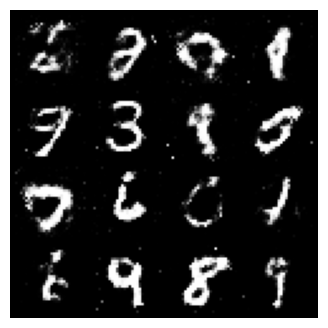

Epoch [12/50] Batch [0/937] D_loss: 1.2983 G_loss: 0.8210 D(real): 0.2147 D(fake): -0.1656
Epoch [12/50] Batch [100/937] D_loss: 1.2124 G_loss: 0.9232 D(real): -0.0164 D(fake): -0.3452
Epoch [12/50] Batch [200/937] D_loss: 1.2563 G_loss: 0.9426 D(real): 0.2021 D(fake): -0.3764
Epoch [12/50] Batch [300/937] D_loss: 1.2711 G_loss: 0.7812 D(real): 0.0351 D(fake): -0.1045
Epoch [12/50] Batch [400/937] D_loss: 1.2321 G_loss: 0.7351 D(real): -0.0717 D(fake): -0.0303
Epoch [12/50] Batch [500/937] D_loss: 1.2250 G_loss: 1.2782 D(real): 0.8399 D(fake): -0.9064
Epoch [12/50] Batch [600/937] D_loss: 1.2592 G_loss: 0.9438 D(real): 0.6775 D(fake): -0.3815
Epoch [12/50] Batch [700/937] D_loss: 1.3007 G_loss: 0.5082 D(real): -0.2160 D(fake): 0.5008
Epoch [12/50] Batch [800/937] D_loss: 1.2558 G_loss: 0.9916 D(real): 0.5104 D(fake): -0.4720
Epoch [12/50] Batch [900/937] D_loss: 1.2432 G_loss: 1.0202 D(real): 0.6136 D(fake): -0.5227

--- Generated samples at epoch 12 ---


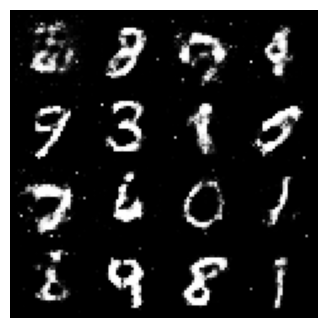

Epoch [13/50] Batch [0/937] D_loss: 1.2128 G_loss: 0.9108 D(real): 0.2850 D(fake): -0.3273
Epoch [13/50] Batch [100/937] D_loss: 1.1749 G_loss: 0.9995 D(real): 0.4760 D(fake): -0.4735
Epoch [13/50] Batch [200/937] D_loss: 1.2408 G_loss: 0.8768 D(real): 0.1081 D(fake): -0.2665
Epoch [13/50] Batch [300/937] D_loss: 1.2901 G_loss: 0.9073 D(real): 0.4714 D(fake): -0.3255
Epoch [13/50] Batch [400/937] D_loss: 1.2840 G_loss: 1.3939 D(real): 1.1007 D(fake): -1.0625
Epoch [13/50] Batch [500/937] D_loss: 1.2631 G_loss: 1.0799 D(real): 0.7402 D(fake): -0.6239
Epoch [13/50] Batch [600/937] D_loss: 1.2199 G_loss: 0.9792 D(real): 0.3745 D(fake): -0.4527
Epoch [13/50] Batch [700/937] D_loss: 1.2169 G_loss: 0.8628 D(real): 0.1849 D(fake): -0.2407
Epoch [13/50] Batch [800/937] D_loss: 1.2257 G_loss: 0.8914 D(real): 0.1465 D(fake): -0.3064
Epoch [13/50] Batch [900/937] D_loss: 1.2214 G_loss: 1.0028 D(real): 0.4771 D(fake): -0.5044

--- Generated samples at epoch 13 ---


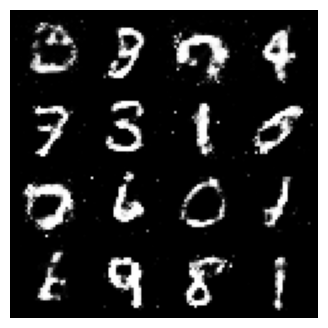

Epoch [14/50] Batch [0/937] D_loss: 1.2195 G_loss: 1.1756 D(real): 0.8308 D(fake): -0.7470
Epoch [14/50] Batch [100/937] D_loss: 1.2162 G_loss: 0.8476 D(real): 0.3324 D(fake): -0.2226
Epoch [14/50] Batch [200/937] D_loss: 1.1933 G_loss: 0.8277 D(real): 0.0685 D(fake): -0.1701
Epoch [14/50] Batch [300/937] D_loss: 1.2353 G_loss: 1.0842 D(real): 0.4064 D(fake): -0.6279
Epoch [14/50] Batch [400/937] D_loss: 1.2247 G_loss: 0.7449 D(real): 0.0505 D(fake): -0.0548
Epoch [14/50] Batch [500/937] D_loss: 1.2521 G_loss: 0.8391 D(real): 0.0301 D(fake): -0.1872
Epoch [14/50] Batch [600/937] D_loss: 1.2402 G_loss: 0.8366 D(real): 0.2107 D(fake): -0.1770
Epoch [14/50] Batch [700/937] D_loss: 1.2845 G_loss: 0.6748 D(real): -0.2256 D(fake): 0.1395
Epoch [14/50] Batch [800/937] D_loss: 1.1701 G_loss: 0.6452 D(real): 0.0347 D(fake): 0.1759
Epoch [14/50] Batch [900/937] D_loss: 1.2665 G_loss: 0.6694 D(real): -0.0706 D(fake): 0.1321

--- Generated samples at epoch 14 ---


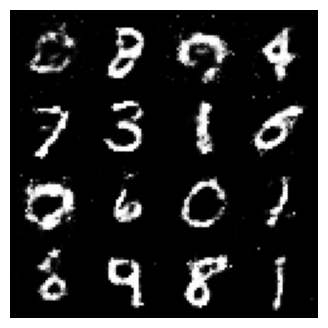

Epoch [15/50] Batch [0/937] D_loss: 1.2200 G_loss: 0.9982 D(real): 0.3600 D(fake): -0.4965
Epoch [15/50] Batch [100/937] D_loss: 1.2813 G_loss: 0.7302 D(real): -0.2159 D(fake): -0.0003
Epoch [15/50] Batch [200/937] D_loss: 1.1946 G_loss: 0.8943 D(real): 0.3004 D(fake): -0.3063
Epoch [15/50] Batch [300/937] D_loss: 1.2516 G_loss: 0.8172 D(real): 0.0944 D(fake): -0.1383
Epoch [15/50] Batch [400/937] D_loss: 1.2781 G_loss: 1.0679 D(real): 0.3888 D(fake): -0.5815
Epoch [15/50] Batch [500/937] D_loss: 1.2087 G_loss: 1.0167 D(real): 0.5368 D(fake): -0.5188
Epoch [15/50] Batch [600/937] D_loss: 1.4032 G_loss: 0.6136 D(real): -0.2352 D(fake): 0.2595
Epoch [15/50] Batch [700/937] D_loss: 1.1415 G_loss: 0.9569 D(real): 0.4832 D(fake): -0.3734
Epoch [15/50] Batch [800/937] D_loss: 1.2589 G_loss: 0.8508 D(real): 0.4023 D(fake): -0.1973
Epoch [15/50] Batch [900/937] D_loss: 1.1858 G_loss: 0.8360 D(real): 0.0657 D(fake): -0.1999

--- Generated samples at epoch 15 ---


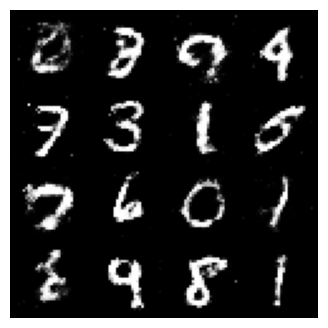

Epoch [16/50] Batch [0/937] D_loss: 1.2296 G_loss: 0.6637 D(real): -0.0941 D(fake): 0.1748
Epoch [16/50] Batch [100/937] D_loss: 1.1885 G_loss: 0.8662 D(real): 0.1800 D(fake): -0.2735
Epoch [16/50] Batch [200/937] D_loss: 1.2677 G_loss: 0.9066 D(real): 0.3860 D(fake): -0.3219
Epoch [16/50] Batch [300/937] D_loss: 1.2130 G_loss: 0.9060 D(real): 0.6704 D(fake): -0.3356
Epoch [16/50] Batch [400/937] D_loss: 1.2723 G_loss: 1.0909 D(real): 0.7693 D(fake): -0.6269
Epoch [16/50] Batch [500/937] D_loss: 1.2300 G_loss: 1.0904 D(real): 0.3294 D(fake): -0.6051
Epoch [16/50] Batch [600/937] D_loss: 1.2010 G_loss: 0.9099 D(real): 0.2459 D(fake): -0.3294
Epoch [16/50] Batch [700/937] D_loss: 1.3135 G_loss: 0.8030 D(real): -0.0457 D(fake): -0.1250
Epoch [16/50] Batch [800/937] D_loss: 1.1773 G_loss: 0.7630 D(real): 0.1305 D(fake): -0.0600
Epoch [16/50] Batch [900/937] D_loss: 1.2437 G_loss: 0.9957 D(real): 0.2687 D(fake): -0.4569

--- Generated samples at epoch 16 ---


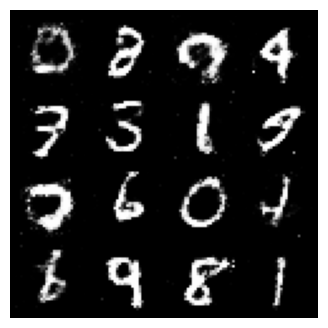

Epoch [17/50] Batch [0/937] D_loss: 1.2052 G_loss: 1.1172 D(real): 0.5222 D(fake): -0.6652
Epoch [17/50] Batch [100/937] D_loss: 1.2416 G_loss: 0.9500 D(real): 0.2919 D(fake): -0.4039
Epoch [17/50] Batch [200/937] D_loss: 1.2934 G_loss: 0.7001 D(real): -0.1551 D(fake): 0.0929
Epoch [17/50] Batch [300/937] D_loss: 1.1099 G_loss: 0.9935 D(real): 0.4451 D(fake): -0.4771
Epoch [17/50] Batch [400/937] D_loss: 1.2632 G_loss: 0.6050 D(real): -0.3036 D(fake): 0.3046
Epoch [17/50] Batch [500/937] D_loss: 1.2739 G_loss: 1.1978 D(real): 0.6194 D(fake): -0.7815
Epoch [17/50] Batch [600/937] D_loss: 1.1953 G_loss: 1.2025 D(real): 0.7084 D(fake): -0.8078
Epoch [17/50] Batch [700/937] D_loss: 1.2650 G_loss: 0.8120 D(real): -0.0837 D(fake): -0.1333
Epoch [17/50] Batch [800/937] D_loss: 1.2529 G_loss: 0.8550 D(real): 0.2191 D(fake): -0.2490
Epoch [17/50] Batch [900/937] D_loss: 1.2211 G_loss: 0.9085 D(real): 0.2328 D(fake): -0.3004

--- Generated samples at epoch 17 ---


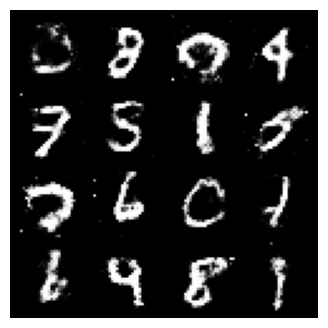

Epoch [18/50] Batch [0/937] D_loss: 1.4253 G_loss: 0.4984 D(real): -0.6132 D(fake): 0.5187
Epoch [18/50] Batch [100/937] D_loss: 1.2730 G_loss: 0.6253 D(real): -0.3141 D(fake): 0.1968
Epoch [18/50] Batch [200/937] D_loss: 1.2196 G_loss: 0.9833 D(real): 0.2837 D(fake): -0.4683
Epoch [18/50] Batch [300/937] D_loss: 1.1077 G_loss: 0.9000 D(real): 0.4088 D(fake): -0.3295
Epoch [18/50] Batch [400/937] D_loss: 1.2126 G_loss: 1.2822 D(real): 0.6743 D(fake): -0.8847
Epoch [18/50] Batch [500/937] D_loss: 1.2430 G_loss: 0.9705 D(real): 0.6015 D(fake): -0.4423
Epoch [18/50] Batch [600/937] D_loss: 1.1756 G_loss: 0.8299 D(real): -0.0602 D(fake): -0.1535
Epoch [18/50] Batch [700/937] D_loss: 1.2633 G_loss: 1.0754 D(real): 0.3690 D(fake): -0.5940
Epoch [18/50] Batch [800/937] D_loss: 1.2102 G_loss: 0.9015 D(real): 0.4989 D(fake): -0.3002
Epoch [18/50] Batch [900/937] D_loss: 1.2959 G_loss: 1.1221 D(real): 0.6835 D(fake): -0.6728

--- Generated samples at epoch 18 ---


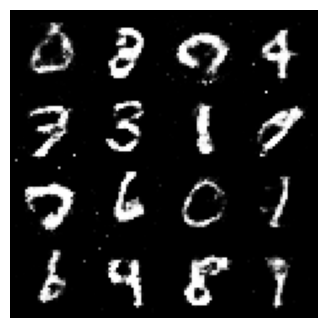

Epoch [19/50] Batch [0/937] D_loss: 1.1758 G_loss: 1.0548 D(real): 0.6703 D(fake): -0.5630
Epoch [19/50] Batch [100/937] D_loss: 1.1483 G_loss: 0.7539 D(real): 0.1741 D(fake): -0.0181
Epoch [19/50] Batch [200/937] D_loss: 1.2453 G_loss: 0.9759 D(real): 0.4933 D(fake): -0.4521
Epoch [19/50] Batch [300/937] D_loss: 1.2126 G_loss: 1.1725 D(real): 0.8776 D(fake): -0.7411
Epoch [19/50] Batch [400/937] D_loss: 1.2399 G_loss: 0.8156 D(real): 0.2856 D(fake): -0.1637
Epoch [19/50] Batch [500/937] D_loss: 1.2884 G_loss: 1.0233 D(real): 0.2728 D(fake): -0.5120
Epoch [19/50] Batch [600/937] D_loss: 1.2489 G_loss: 0.7503 D(real): 0.1226 D(fake): -0.0371
Epoch [19/50] Batch [700/937] D_loss: 1.2318 G_loss: 1.0719 D(real): 0.5944 D(fake): -0.5941
Epoch [19/50] Batch [800/937] D_loss: 1.2111 G_loss: 0.7513 D(real): -0.0128 D(fake): -0.0521
Epoch [19/50] Batch [900/937] D_loss: 1.2759 G_loss: 1.1220 D(real): 0.6243 D(fake): -0.6609

--- Generated samples at epoch 19 ---


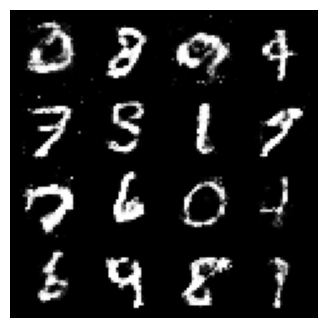

Epoch [20/50] Batch [0/937] D_loss: 1.2568 G_loss: 0.6309 D(real): -0.0354 D(fake): 0.2127
Epoch [20/50] Batch [100/937] D_loss: 1.2516 G_loss: 1.2761 D(real): 0.5576 D(fake): -0.9014
Epoch [20/50] Batch [200/937] D_loss: 1.2340 G_loss: 0.9929 D(real): 0.7887 D(fake): -0.4528
Epoch [20/50] Batch [300/937] D_loss: 1.2202 G_loss: 1.4670 D(real): 1.0291 D(fake): -1.1595
Epoch [20/50] Batch [400/937] D_loss: 1.1909 G_loss: 0.7300 D(real): 0.1557 D(fake): -0.0029
Epoch [20/50] Batch [500/937] D_loss: 1.2625 G_loss: 0.9057 D(real): -0.0556 D(fake): -0.3121
Epoch [20/50] Batch [600/937] D_loss: 1.3378 G_loss: 1.2234 D(real): 0.7437 D(fake): -0.8152
Epoch [20/50] Batch [700/937] D_loss: 1.2514 G_loss: 0.9152 D(real): 0.5320 D(fake): -0.3314
Epoch [20/50] Batch [800/937] D_loss: 1.2987 G_loss: 1.0580 D(real): 0.3945 D(fake): -0.5487
Epoch [20/50] Batch [900/937] D_loss: 1.2409 G_loss: 0.8345 D(real): 0.0034 D(fake): -0.1815

--- Generated samples at epoch 20 ---


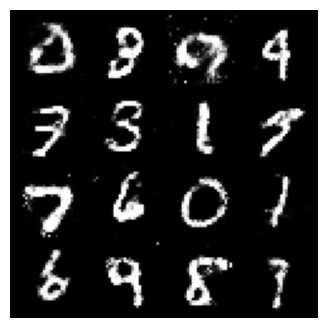

Epoch [21/50] Batch [0/937] D_loss: 1.1829 G_loss: 1.0206 D(real): 0.5048 D(fake): -0.4847
Epoch [21/50] Batch [100/937] D_loss: 1.1931 G_loss: 1.1105 D(real): 0.3633 D(fake): -0.6456
Epoch [21/50] Batch [200/937] D_loss: 1.2533 G_loss: 1.0884 D(real): 0.7872 D(fake): -0.6191
Epoch [21/50] Batch [300/937] D_loss: 1.1467 G_loss: 0.8674 D(real): 0.2159 D(fake): -0.2454
Epoch [21/50] Batch [400/937] D_loss: 1.2570 G_loss: 0.9321 D(real): 0.2843 D(fake): -0.3581
Epoch [21/50] Batch [500/937] D_loss: 1.1444 G_loss: 0.9957 D(real): 0.3942 D(fake): -0.4424
Epoch [21/50] Batch [600/937] D_loss: 1.1412 G_loss: 1.1328 D(real): 0.9226 D(fake): -0.6803
Epoch [21/50] Batch [700/937] D_loss: 1.2509 G_loss: 1.0821 D(real): 0.5688 D(fake): -0.5943
Epoch [21/50] Batch [800/937] D_loss: 1.2342 G_loss: 0.8705 D(real): 0.1213 D(fake): -0.2801
Epoch [21/50] Batch [900/937] D_loss: 1.2299 G_loss: 0.8837 D(real): 0.4110 D(fake): -0.2909

--- Generated samples at epoch 21 ---


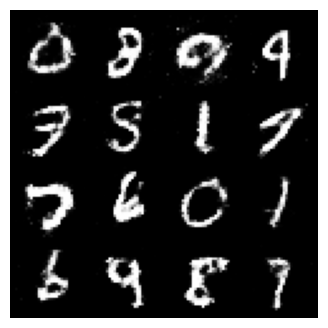

Epoch [22/50] Batch [0/937] D_loss: 1.2381 G_loss: 0.8865 D(real): 0.2109 D(fake): -0.2815
Epoch [22/50] Batch [100/937] D_loss: 1.2101 G_loss: 0.8018 D(real): 0.1631 D(fake): -0.1048
Epoch [22/50] Batch [200/937] D_loss: 1.2316 G_loss: 0.7629 D(real): 0.1121 D(fake): -0.0461
Epoch [22/50] Batch [300/937] D_loss: 1.1978 G_loss: 0.7984 D(real): 0.1721 D(fake): -0.1109
Epoch [22/50] Batch [400/937] D_loss: 1.1670 G_loss: 0.8277 D(real): 0.2703 D(fake): -0.1752
Epoch [22/50] Batch [500/937] D_loss: 1.2164 G_loss: 0.9632 D(real): 0.2649 D(fake): -0.4063
Epoch [22/50] Batch [600/937] D_loss: 1.2608 G_loss: 0.6801 D(real): -0.2405 D(fake): 0.1277
Epoch [22/50] Batch [700/937] D_loss: 1.2971 G_loss: 0.7099 D(real): -0.4700 D(fake): 0.0747
Epoch [22/50] Batch [800/937] D_loss: 1.1526 G_loss: 0.8973 D(real): 0.1722 D(fake): -0.2744
Epoch [22/50] Batch [900/937] D_loss: 1.2225 G_loss: 0.9479 D(real): 0.0696 D(fake): -0.3847

--- Generated samples at epoch 22 ---


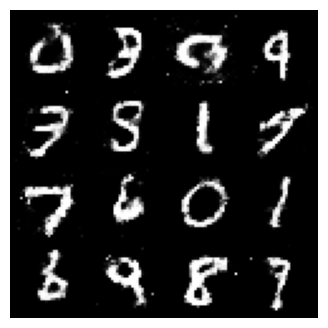

Epoch [23/50] Batch [0/937] D_loss: 1.1414 G_loss: 0.9518 D(real): -0.0351 D(fake): -0.3855
Epoch [23/50] Batch [100/937] D_loss: 1.1657 G_loss: 0.6026 D(real): -0.0222 D(fake): 0.2953
Epoch [23/50] Batch [200/937] D_loss: 1.1443 G_loss: 1.0143 D(real): 0.4026 D(fake): -0.4775
Epoch [23/50] Batch [300/937] D_loss: 1.2065 G_loss: 0.8581 D(real): 0.4803 D(fake): -0.2286
Epoch [23/50] Batch [400/937] D_loss: 1.2070 G_loss: 0.7931 D(real): 0.0536 D(fake): -0.1373
Epoch [23/50] Batch [500/937] D_loss: 1.1499 G_loss: 1.1899 D(real): 0.6732 D(fake): -0.7545
Epoch [23/50] Batch [600/937] D_loss: 1.2243 G_loss: 1.0019 D(real): 0.6886 D(fake): -0.4647
Epoch [23/50] Batch [700/937] D_loss: 1.2683 G_loss: 0.7130 D(real): 0.0848 D(fake): 0.0646
Epoch [23/50] Batch [800/937] D_loss: 1.2441 G_loss: 1.2359 D(real): 0.6595 D(fake): -0.8533
Epoch [23/50] Batch [900/937] D_loss: 1.3144 G_loss: 1.2164 D(real): 0.6358 D(fake): -0.7918

--- Generated samples at epoch 23 ---


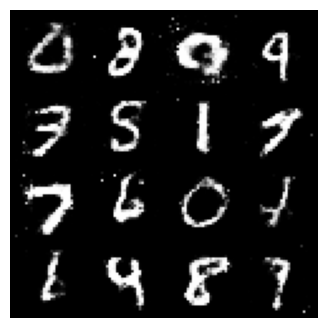

Epoch [24/50] Batch [0/937] D_loss: 1.2116 G_loss: 1.4987 D(real): 1.0901 D(fake): -1.2102
Epoch [24/50] Batch [100/937] D_loss: 1.2658 G_loss: 0.9630 D(real): 0.1478 D(fake): -0.4158
Epoch [24/50] Batch [200/937] D_loss: 1.1475 G_loss: 0.7986 D(real): 0.3278 D(fake): -0.1076
Epoch [24/50] Batch [300/937] D_loss: 1.2308 G_loss: 0.5797 D(real): -0.0249 D(fake): 0.3275
Epoch [24/50] Batch [400/937] D_loss: 1.2359 G_loss: 0.8431 D(real): 0.0428 D(fake): -0.2217
Epoch [24/50] Batch [500/937] D_loss: 1.2961 G_loss: 1.0138 D(real): 0.4084 D(fake): -0.4978
Epoch [24/50] Batch [600/937] D_loss: 1.1867 G_loss: 0.8070 D(real): 0.0697 D(fake): -0.1356
Epoch [24/50] Batch [700/937] D_loss: 1.1844 G_loss: 1.2787 D(real): 0.8357 D(fake): -0.8884
Epoch [24/50] Batch [800/937] D_loss: 1.3650 G_loss: 1.4285 D(real): 1.1408 D(fake): -1.1133
Epoch [24/50] Batch [900/937] D_loss: 1.2567 G_loss: 0.7722 D(real): 0.0920 D(fake): -0.0792

--- Generated samples at epoch 24 ---


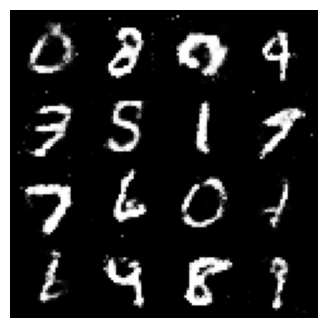

Epoch [25/50] Batch [0/937] D_loss: 1.2388 G_loss: 1.1202 D(real): 0.7242 D(fake): -0.6640
Epoch [25/50] Batch [100/937] D_loss: 1.2173 G_loss: 0.7171 D(real): 0.0122 D(fake): 0.0799
Epoch [25/50] Batch [200/937] D_loss: 1.1606 G_loss: 1.0806 D(real): 0.4416 D(fake): -0.5742
Epoch [25/50] Batch [300/937] D_loss: 1.1273 G_loss: 1.1285 D(real): 0.4787 D(fake): -0.6741
Epoch [25/50] Batch [400/937] D_loss: 1.1840 G_loss: 1.1451 D(real): 0.6583 D(fake): -0.7090
Epoch [25/50] Batch [500/937] D_loss: 1.2494 G_loss: 0.7273 D(real): 0.0387 D(fake): 0.0040
Epoch [25/50] Batch [600/937] D_loss: 1.1842 G_loss: 0.9540 D(real): 0.7382 D(fake): -0.3932
Epoch [25/50] Batch [700/937] D_loss: 1.2071 G_loss: 0.9800 D(real): 0.4464 D(fake): -0.4029
Epoch [25/50] Batch [800/937] D_loss: 1.3339 G_loss: 0.6621 D(real): -0.3591 D(fake): 0.1460
Epoch [25/50] Batch [900/937] D_loss: 1.1677 G_loss: 1.1359 D(real): 0.5568 D(fake): -0.6591

--- Generated samples at epoch 25 ---


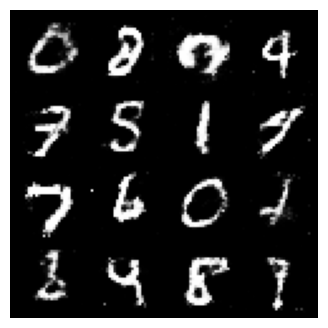

Epoch [26/50] Batch [0/937] D_loss: 1.2785 G_loss: 1.1074 D(real): 0.9880 D(fake): -0.6371
Epoch [26/50] Batch [100/937] D_loss: 1.2428 G_loss: 0.9999 D(real): 0.5161 D(fake): -0.4691
Epoch [26/50] Batch [200/937] D_loss: 1.2426 G_loss: 0.7960 D(real): 0.0356 D(fake): -0.0855
Epoch [26/50] Batch [300/937] D_loss: 1.1611 G_loss: 0.9517 D(real): 0.4991 D(fake): -0.3773
Epoch [26/50] Batch [400/937] D_loss: 1.2521 G_loss: 0.7499 D(real): -0.1948 D(fake): 0.0035
Epoch [26/50] Batch [500/937] D_loss: 1.2269 G_loss: 0.9757 D(real): 0.4704 D(fake): -0.4095
Epoch [26/50] Batch [600/937] D_loss: 1.2476 G_loss: 0.6367 D(real): -0.1717 D(fake): 0.2275
Epoch [26/50] Batch [700/937] D_loss: 1.1770 G_loss: 0.7547 D(real): 0.1217 D(fake): -0.0199
Epoch [26/50] Batch [800/937] D_loss: 1.2974 G_loss: 0.6345 D(real): -0.1176 D(fake): 0.2196
Epoch [26/50] Batch [900/937] D_loss: 1.2928 G_loss: 0.9778 D(real): 0.3004 D(fake): -0.4269

--- Generated samples at epoch 26 ---


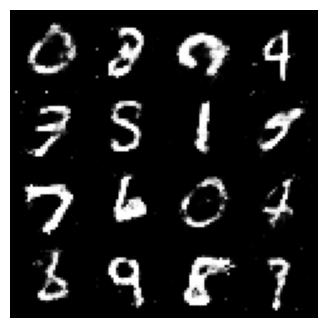

Epoch [27/50] Batch [0/937] D_loss: 1.4611 G_loss: 1.4940 D(real): 1.3017 D(fake): -1.1849
Epoch [27/50] Batch [100/937] D_loss: 1.2436 G_loss: 0.8115 D(real): 0.1102 D(fake): -0.1236
Epoch [27/50] Batch [200/937] D_loss: 1.1971 G_loss: 0.8838 D(real): 0.1526 D(fake): -0.2579
Epoch [27/50] Batch [300/937] D_loss: 1.1417 G_loss: 0.9156 D(real): 0.5965 D(fake): -0.2972
Epoch [27/50] Batch [400/937] D_loss: 1.2516 G_loss: 0.9960 D(real): 0.4379 D(fake): -0.4413
Epoch [27/50] Batch [500/937] D_loss: 1.2872 G_loss: 0.9815 D(real): 0.2839 D(fake): -0.4427
Epoch [27/50] Batch [600/937] D_loss: 1.3211 G_loss: 0.6952 D(real): -0.2109 D(fake): 0.1465
Epoch [27/50] Batch [700/937] D_loss: 1.2248 G_loss: 0.8787 D(real): 0.0109 D(fake): -0.2517
Epoch [27/50] Batch [800/937] D_loss: 1.2487 G_loss: 0.8319 D(real): 0.1252 D(fake): -0.1527
Epoch [27/50] Batch [900/937] D_loss: 1.2290 G_loss: 1.2986 D(real): 0.8548 D(fake): -0.9363

--- Generated samples at epoch 27 ---


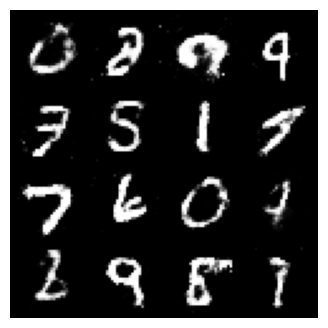

Epoch [28/50] Batch [0/937] D_loss: 1.2707 G_loss: 0.7234 D(real): -0.0135 D(fake): 0.0520
Epoch [28/50] Batch [100/937] D_loss: 1.2393 G_loss: 0.7448 D(real): 0.2654 D(fake): -0.0178
Epoch [28/50] Batch [200/937] D_loss: 1.1543 G_loss: 0.8978 D(real): 0.3575 D(fake): -0.2898
Epoch [28/50] Batch [300/937] D_loss: 1.1533 G_loss: 1.0015 D(real): 0.6986 D(fake): -0.4459
Epoch [28/50] Batch [400/937] D_loss: 1.1816 G_loss: 0.7207 D(real): 0.1085 D(fake): 0.0559
Epoch [28/50] Batch [500/937] D_loss: 1.2224 G_loss: 0.9680 D(real): 0.6518 D(fake): -0.3972
Epoch [28/50] Batch [600/937] D_loss: 1.3134 G_loss: 0.6461 D(real): -0.0188 D(fake): 0.1960
Epoch [28/50] Batch [700/937] D_loss: 1.2126 G_loss: 1.1137 D(real): 0.5067 D(fake): -0.6509
Epoch [28/50] Batch [800/937] D_loss: 1.2156 G_loss: 0.7963 D(real): -0.0909 D(fake): -0.1219
Epoch [28/50] Batch [900/937] D_loss: 1.2121 G_loss: 0.9202 D(real): 0.0528 D(fake): -0.3133

--- Generated samples at epoch 28 ---


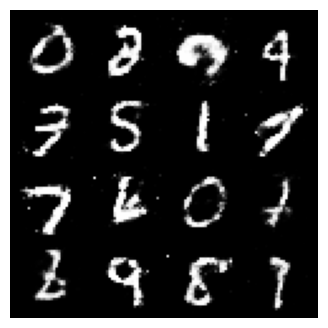

Epoch [29/50] Batch [0/937] D_loss: 1.2113 G_loss: 0.9058 D(real): 0.0591 D(fake): -0.3019
Epoch [29/50] Batch [100/937] D_loss: 1.3739 G_loss: 1.2281 D(real): 0.8472 D(fake): -0.8136
Epoch [29/50] Batch [200/937] D_loss: 1.1622 G_loss: 0.9108 D(real): 0.3466 D(fake): -0.3380
Epoch [29/50] Batch [300/937] D_loss: 1.1913 G_loss: 1.1181 D(real): 0.7079 D(fake): -0.6708
Epoch [29/50] Batch [400/937] D_loss: 1.1822 G_loss: 0.9143 D(real): 0.3957 D(fake): -0.2882
Epoch [29/50] Batch [500/937] D_loss: 1.1833 G_loss: 0.8822 D(real): 0.4994 D(fake): -0.2688
Epoch [29/50] Batch [600/937] D_loss: 1.2069 G_loss: 0.9015 D(real): 0.3360 D(fake): -0.2859
Epoch [29/50] Batch [700/937] D_loss: 1.1286 G_loss: 1.0561 D(real): 0.3964 D(fake): -0.5343
Epoch [29/50] Batch [800/937] D_loss: 1.1449 G_loss: 0.9117 D(real): 0.4756 D(fake): -0.2981
Epoch [29/50] Batch [900/937] D_loss: 1.2244 G_loss: 1.0030 D(real): 0.2616 D(fake): -0.4831

--- Generated samples at epoch 29 ---


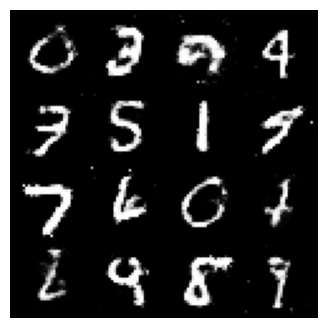

Epoch [30/50] Batch [0/937] D_loss: 1.2028 G_loss: 1.1816 D(real): 0.8364 D(fake): -0.7446
Epoch [30/50] Batch [100/937] D_loss: 1.2738 G_loss: 0.7549 D(real): -0.1684 D(fake): -0.0452
Epoch [30/50] Batch [200/937] D_loss: 1.3769 G_loss: 0.5900 D(real): -0.3531 D(fake): 0.3149
Epoch [30/50] Batch [300/937] D_loss: 1.1859 G_loss: 0.9719 D(real): 0.1809 D(fake): -0.4078
Epoch [30/50] Batch [400/937] D_loss: 1.1994 G_loss: 0.8701 D(real): 0.1311 D(fake): -0.2282
Epoch [30/50] Batch [500/937] D_loss: 1.2357 G_loss: 0.8747 D(real): 0.0195 D(fake): -0.2580
Epoch [30/50] Batch [600/937] D_loss: 1.2872 G_loss: 1.3001 D(real): 0.7854 D(fake): -0.9152
Epoch [30/50] Batch [700/937] D_loss: 1.1589 G_loss: 0.9607 D(real): 0.4410 D(fake): -0.4147
Epoch [30/50] Batch [800/937] D_loss: 1.2765 G_loss: 0.8275 D(real): 0.1668 D(fake): -0.1116
Epoch [30/50] Batch [900/937] D_loss: 1.1151 G_loss: 0.9414 D(real): 0.5104 D(fake): -0.3434

--- Generated samples at epoch 30 ---


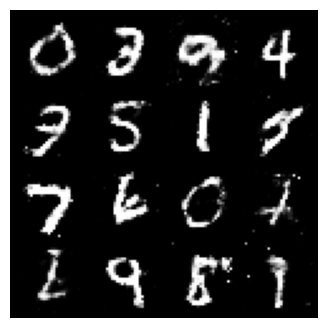

Epoch [31/50] Batch [0/937] D_loss: 1.1948 G_loss: 0.8492 D(real): 0.3947 D(fake): -0.1911
Epoch [31/50] Batch [100/937] D_loss: 1.2855 G_loss: 1.0080 D(real): 0.6217 D(fake): -0.4617
Epoch [31/50] Batch [200/937] D_loss: 1.2009 G_loss: 0.9598 D(real): 0.5236 D(fake): -0.3604
Epoch [31/50] Batch [300/937] D_loss: 1.2129 G_loss: 0.9127 D(real): 0.1039 D(fake): -0.3092
Epoch [31/50] Batch [400/937] D_loss: 1.0966 G_loss: 0.9667 D(real): 0.5146 D(fake): -0.4105
Epoch [31/50] Batch [500/937] D_loss: 1.1660 G_loss: 1.1511 D(real): 0.7165 D(fake): -0.6993
Epoch [31/50] Batch [600/937] D_loss: 1.1887 G_loss: 0.6806 D(real): 0.1180 D(fake): 0.1669
Epoch [31/50] Batch [700/937] D_loss: 1.1492 G_loss: 0.9085 D(real): 0.1658 D(fake): -0.3083
Epoch [31/50] Batch [800/937] D_loss: 1.2766 G_loss: 0.7388 D(real): -0.0766 D(fake): 0.0368
Epoch [31/50] Batch [900/937] D_loss: 1.2801 G_loss: 0.9352 D(real): 0.4265 D(fake): -0.3644

--- Generated samples at epoch 31 ---


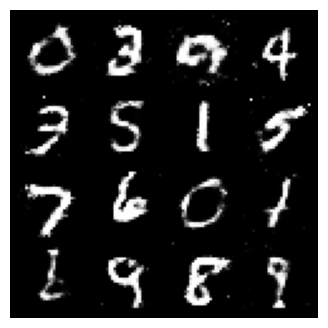

Epoch [32/50] Batch [0/937] D_loss: 1.2978 G_loss: 1.1922 D(real): 1.0100 D(fake): -0.7568
Epoch [32/50] Batch [100/937] D_loss: 1.2286 G_loss: 1.0378 D(real): 0.5829 D(fake): -0.5305
Epoch [32/50] Batch [200/937] D_loss: 1.2356 G_loss: 0.8507 D(real): 0.1749 D(fake): -0.2189
Epoch [32/50] Batch [300/937] D_loss: 1.2329 G_loss: 0.9575 D(real): 0.1305 D(fake): -0.3843
Epoch [32/50] Batch [400/937] D_loss: 1.2152 G_loss: 0.8023 D(real): 0.0549 D(fake): -0.1264
Epoch [32/50] Batch [500/937] D_loss: 1.2276 G_loss: 1.0521 D(real): 0.5441 D(fake): -0.5650
Epoch [32/50] Batch [600/937] D_loss: 1.2400 G_loss: 1.0765 D(real): 0.3919 D(fake): -0.6155
Epoch [32/50] Batch [700/937] D_loss: 1.1295 G_loss: 0.8579 D(real): 0.3463 D(fake): -0.2229
Epoch [32/50] Batch [800/937] D_loss: 1.2073 G_loss: 0.9506 D(real): 0.4415 D(fake): -0.3373
Epoch [32/50] Batch [900/937] D_loss: 1.1683 G_loss: 1.1065 D(real): 0.3287 D(fake): -0.6404

--- Generated samples at epoch 32 ---


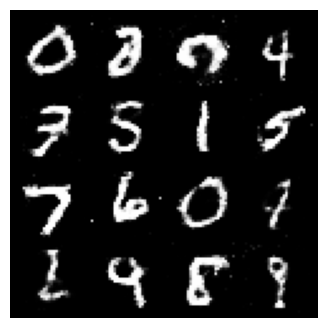

Epoch [33/50] Batch [0/937] D_loss: 1.1950 G_loss: 0.7405 D(real): 0.2639 D(fake): 0.0237
Epoch [33/50] Batch [100/937] D_loss: 1.1973 G_loss: 0.7404 D(real): 0.2261 D(fake): 0.0269
Epoch [33/50] Batch [200/937] D_loss: 1.2497 G_loss: 0.6422 D(real): -0.2806 D(fake): 0.2440
Epoch [33/50] Batch [300/937] D_loss: 1.2928 G_loss: 0.7712 D(real): 0.0616 D(fake): -0.0564
Epoch [33/50] Batch [400/937] D_loss: 1.2123 G_loss: 1.0489 D(real): 0.4083 D(fake): -0.5205
Epoch [33/50] Batch [500/937] D_loss: 1.1616 G_loss: 0.7725 D(real): 0.3173 D(fake): -0.0188
Epoch [33/50] Batch [600/937] D_loss: 1.1848 G_loss: 0.8928 D(real): 0.4901 D(fake): -0.3013
Epoch [33/50] Batch [700/937] D_loss: 1.1640 G_loss: 0.8923 D(real): 0.2345 D(fake): -0.2550
Epoch [33/50] Batch [800/937] D_loss: 1.2626 G_loss: 0.7079 D(real): -0.3050 D(fake): 0.1407
Epoch [33/50] Batch [900/937] D_loss: 1.1912 G_loss: 1.1409 D(real): 0.8256 D(fake): -0.6904

--- Generated samples at epoch 33 ---


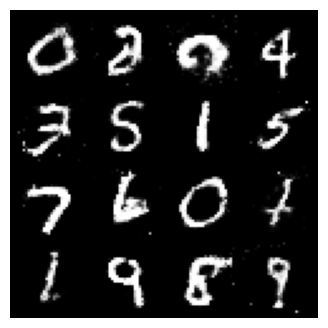

Epoch [34/50] Batch [0/937] D_loss: 1.1633 G_loss: 0.9430 D(real): 0.3912 D(fake): -0.3703
Epoch [34/50] Batch [100/937] D_loss: 1.2356 G_loss: 0.7084 D(real): 0.0313 D(fake): 0.0813
Epoch [34/50] Batch [200/937] D_loss: 1.1801 G_loss: 1.0203 D(real): 0.2347 D(fake): -0.4735
Epoch [34/50] Batch [300/937] D_loss: 1.2729 G_loss: 1.1745 D(real): 0.6894 D(fake): -0.7432
Epoch [34/50] Batch [400/937] D_loss: 1.1766 G_loss: 0.9482 D(real): 0.3638 D(fake): -0.3522
Epoch [34/50] Batch [500/937] D_loss: 1.2176 G_loss: 0.7696 D(real): 0.3526 D(fake): -0.0474
Epoch [34/50] Batch [600/937] D_loss: 1.2348 G_loss: 0.7841 D(real): -0.0791 D(fake): -0.0823
Epoch [34/50] Batch [700/937] D_loss: 1.3026 G_loss: 0.6782 D(real): -0.3018 D(fake): 0.1357
Epoch [34/50] Batch [800/937] D_loss: 1.2389 G_loss: 0.8509 D(real): 0.2043 D(fake): -0.1542
Epoch [34/50] Batch [900/937] D_loss: 1.2278 G_loss: 1.1271 D(real): 0.6238 D(fake): -0.6014

--- Generated samples at epoch 34 ---


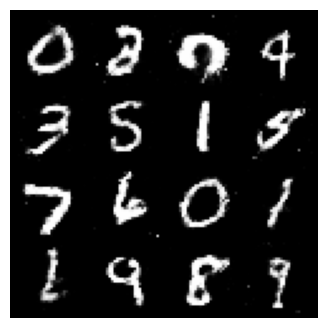

Epoch [35/50] Batch [0/937] D_loss: 1.2370 G_loss: 1.2113 D(real): 0.8111 D(fake): -0.7588
Epoch [35/50] Batch [100/937] D_loss: 1.2160 G_loss: 1.1495 D(real): 0.6125 D(fake): -0.6950
Epoch [35/50] Batch [200/937] D_loss: 1.3237 G_loss: 0.7378 D(real): -0.2956 D(fake): 0.0162
Epoch [35/50] Batch [300/937] D_loss: 1.2761 G_loss: 1.3384 D(real): 0.8492 D(fake): -0.9488
Epoch [35/50] Batch [400/937] D_loss: 1.1384 G_loss: 0.7909 D(real): 0.4002 D(fake): -0.1055
Epoch [35/50] Batch [500/937] D_loss: 1.3790 G_loss: 0.8227 D(real): -0.2784 D(fake): -0.1006
Epoch [35/50] Batch [600/937] D_loss: 1.3001 G_loss: 0.5526 D(real): -0.0302 D(fake): 0.4389
Epoch [35/50] Batch [700/937] D_loss: 1.2079 G_loss: 1.1633 D(real): 0.5945 D(fake): -0.7287
Epoch [35/50] Batch [800/937] D_loss: 1.1577 G_loss: 1.0203 D(real): 0.5320 D(fake): -0.4878
Epoch [35/50] Batch [900/937] D_loss: 1.2505 G_loss: 0.6662 D(real): -0.0957 D(fake): 0.1910

--- Generated samples at epoch 35 ---


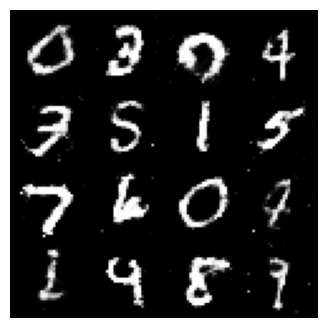

Epoch [36/50] Batch [0/937] D_loss: 1.3249 G_loss: 1.0886 D(real): 0.7193 D(fake): -0.6171
Epoch [36/50] Batch [100/937] D_loss: 1.2261 G_loss: 0.7878 D(real): -0.0261 D(fake): -0.1292
Epoch [36/50] Batch [200/937] D_loss: 1.2169 G_loss: 1.1990 D(real): 0.7266 D(fake): -0.7446
Epoch [36/50] Batch [300/937] D_loss: 1.1821 G_loss: 1.1628 D(real): 0.5791 D(fake): -0.6964
Epoch [36/50] Batch [400/937] D_loss: 1.1169 G_loss: 0.8201 D(real): 0.1996 D(fake): -0.1622
Epoch [36/50] Batch [500/937] D_loss: 1.3572 G_loss: 1.0964 D(real): 0.4948 D(fake): -0.6171
Epoch [36/50] Batch [600/937] D_loss: 1.1330 G_loss: 1.0466 D(real): 0.4382 D(fake): -0.5150
Epoch [36/50] Batch [700/937] D_loss: 1.2604 G_loss: 0.8542 D(real): 0.5191 D(fake): -0.1961
Epoch [36/50] Batch [800/937] D_loss: 1.1189 G_loss: 0.7546 D(real): 0.1758 D(fake): 0.0100
Epoch [36/50] Batch [900/937] D_loss: 1.1870 G_loss: 0.9530 D(real): 0.2934 D(fake): -0.3634

--- Generated samples at epoch 36 ---


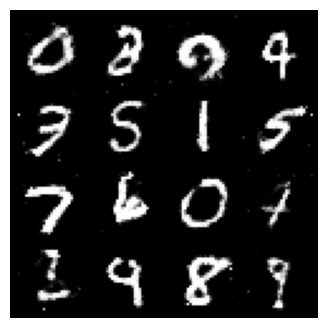

Epoch [37/50] Batch [0/937] D_loss: 1.2474 G_loss: 1.0177 D(real): 0.5108 D(fake): -0.4868
Epoch [37/50] Batch [100/937] D_loss: 1.2417 G_loss: 1.2213 D(real): 0.7147 D(fake): -0.8091
Epoch [37/50] Batch [200/937] D_loss: 1.1858 G_loss: 1.0568 D(real): 0.4705 D(fake): -0.5290
Epoch [37/50] Batch [300/937] D_loss: 1.1621 G_loss: 0.9130 D(real): 0.5261 D(fake): -0.2647
Epoch [37/50] Batch [400/937] D_loss: 1.1881 G_loss: 0.7806 D(real): 0.1836 D(fake): -0.0704
Epoch [37/50] Batch [500/937] D_loss: 1.1683 G_loss: 1.0192 D(real): 0.3555 D(fake): -0.4296
Epoch [37/50] Batch [600/937] D_loss: 1.1506 G_loss: 0.8991 D(real): 0.1389 D(fake): -0.2474
Epoch [37/50] Batch [700/937] D_loss: 1.2477 G_loss: 1.2702 D(real): 1.1569 D(fake): -0.8778
Epoch [37/50] Batch [800/937] D_loss: 1.2125 G_loss: 0.8315 D(real): -0.0250 D(fake): -0.1587
Epoch [37/50] Batch [900/937] D_loss: 1.2574 G_loss: 1.0259 D(real): 0.7248 D(fake): -0.4616

--- Generated samples at epoch 37 ---


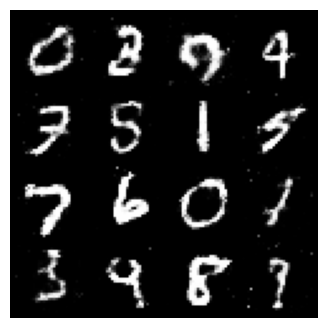

Epoch [38/50] Batch [0/937] D_loss: 1.3150 G_loss: 0.9858 D(real): 0.7496 D(fake): -0.4142
Epoch [38/50] Batch [100/937] D_loss: 1.1000 G_loss: 0.9747 D(real): 0.3732 D(fake): -0.3953
Epoch [38/50] Batch [200/937] D_loss: 1.4279 G_loss: 1.2685 D(real): 1.1435 D(fake): -0.8733
Epoch [38/50] Batch [300/937] D_loss: 1.1758 G_loss: 1.0121 D(real): 0.5549 D(fake): -0.4485
Epoch [38/50] Batch [400/937] D_loss: 1.1614 G_loss: 0.9307 D(real): 0.6438 D(fake): -0.3534
Epoch [38/50] Batch [500/937] D_loss: 1.2396 G_loss: 0.9864 D(real): 0.4120 D(fake): -0.4089
Epoch [38/50] Batch [600/937] D_loss: 1.2029 G_loss: 0.8437 D(real): 0.3667 D(fake): -0.1712
Epoch [38/50] Batch [700/937] D_loss: 1.1953 G_loss: 0.8032 D(real): 0.0825 D(fake): -0.0689
Epoch [38/50] Batch [800/937] D_loss: 1.1738 G_loss: 1.1827 D(real): 0.6654 D(fake): -0.7459
Epoch [38/50] Batch [900/937] D_loss: 1.2245 G_loss: 0.9705 D(real): 0.5049 D(fake): -0.4037

--- Generated samples at epoch 38 ---


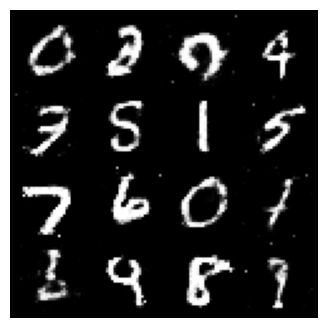

Epoch [39/50] Batch [0/937] D_loss: 1.1680 G_loss: 0.9029 D(real): 0.1996 D(fake): -0.3180
Epoch [39/50] Batch [100/937] D_loss: 1.1485 G_loss: 1.0166 D(real): 0.4493 D(fake): -0.4447
Epoch [39/50] Batch [200/937] D_loss: 1.1173 G_loss: 0.9361 D(real): 0.4308 D(fake): -0.3515
Epoch [39/50] Batch [300/937] D_loss: 1.2712 G_loss: 0.8926 D(real): -0.0214 D(fake): -0.2514
Epoch [39/50] Batch [400/937] D_loss: 1.2195 G_loss: 0.6519 D(real): -0.1263 D(fake): 0.2227
Epoch [39/50] Batch [500/937] D_loss: 1.1982 G_loss: 0.9174 D(real): 0.3387 D(fake): -0.3356
Epoch [39/50] Batch [600/937] D_loss: 1.2679 G_loss: 1.0951 D(real): 0.4715 D(fake): -0.6163
Epoch [39/50] Batch [700/937] D_loss: 1.2019 G_loss: 1.2426 D(real): 0.8782 D(fake): -0.8163
Epoch [39/50] Batch [800/937] D_loss: 1.2400 G_loss: 0.7515 D(real): 0.0649 D(fake): -0.0295
Epoch [39/50] Batch [900/937] D_loss: 1.1168 G_loss: 1.1887 D(real): 0.5191 D(fake): -0.7383

--- Generated samples at epoch 39 ---


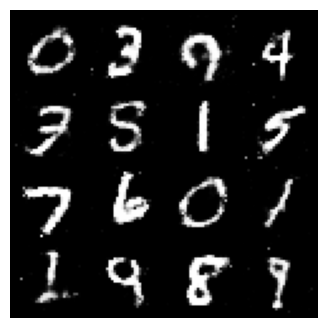

Epoch [40/50] Batch [0/937] D_loss: 1.2085 G_loss: 0.8175 D(real): 0.3282 D(fake): -0.1443
Epoch [40/50] Batch [100/937] D_loss: 1.2263 G_loss: 1.2517 D(real): 1.1897 D(fake): -0.8452
Epoch [40/50] Batch [200/937] D_loss: 1.2836 G_loss: 0.7190 D(real): -0.0932 D(fake): 0.0910
Epoch [40/50] Batch [300/937] D_loss: 1.2582 G_loss: 0.6978 D(real): -0.3388 D(fake): 0.1564
Epoch [40/50] Batch [400/937] D_loss: 1.1214 G_loss: 0.6834 D(real): 0.1875 D(fake): 0.0898
Epoch [40/50] Batch [500/937] D_loss: 1.1869 G_loss: 1.0113 D(real): 0.3350 D(fake): -0.4579
Epoch [40/50] Batch [600/937] D_loss: 1.2118 G_loss: 1.2345 D(real): 0.3045 D(fake): -0.8233
Epoch [40/50] Batch [700/937] D_loss: 1.1781 G_loss: 0.7070 D(real): 0.2875 D(fake): 0.1270
Epoch [40/50] Batch [800/937] D_loss: 1.1032 G_loss: 0.9797 D(real): 0.6016 D(fake): -0.3715
Epoch [40/50] Batch [900/937] D_loss: 1.3171 G_loss: 1.1228 D(real): 0.2936 D(fake): -0.6147

--- Generated samples at epoch 40 ---


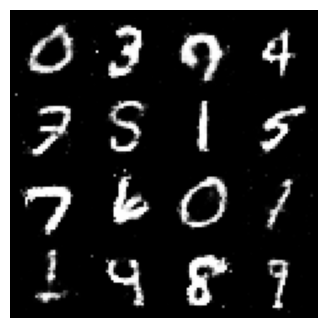

Epoch [41/50] Batch [0/937] D_loss: 1.2206 G_loss: 0.9479 D(real): 0.3559 D(fake): -0.3511
Epoch [41/50] Batch [100/937] D_loss: 1.1742 G_loss: 1.0160 D(real): 0.6124 D(fake): -0.4874
Epoch [41/50] Batch [200/937] D_loss: 1.2243 G_loss: 1.0058 D(real): 0.1491 D(fake): -0.4424
Epoch [41/50] Batch [300/937] D_loss: 1.2612 G_loss: 0.6427 D(real): -0.2065 D(fake): 0.2709
Epoch [41/50] Batch [400/937] D_loss: 1.2681 G_loss: 1.0747 D(real): 0.8949 D(fake): -0.6107
Epoch [41/50] Batch [500/937] D_loss: 1.1708 G_loss: 1.1864 D(real): 0.8000 D(fake): -0.7451
Epoch [41/50] Batch [600/937] D_loss: 1.1866 G_loss: 0.9271 D(real): 0.3216 D(fake): -0.3119
Epoch [41/50] Batch [700/937] D_loss: 1.0679 G_loss: 0.9871 D(real): 0.4998 D(fake): -0.4143
Epoch [41/50] Batch [800/937] D_loss: 1.3036 G_loss: 1.1542 D(real): 0.1508 D(fake): -0.6627
Epoch [41/50] Batch [900/937] D_loss: 1.1886 G_loss: 0.9602 D(real): 0.6120 D(fake): -0.3008

--- Generated samples at epoch 41 ---


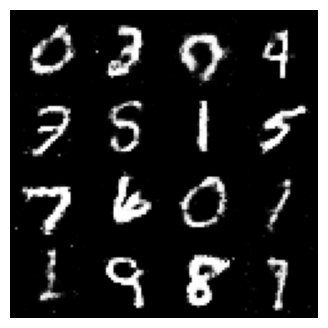

Epoch [42/50] Batch [0/937] D_loss: 1.3202 G_loss: 1.1913 D(real): 0.1211 D(fake): -0.7529
Epoch [42/50] Batch [100/937] D_loss: 1.1876 G_loss: 0.9480 D(real): 0.3065 D(fake): -0.3520
Epoch [42/50] Batch [200/937] D_loss: 1.2268 G_loss: 0.8618 D(real): 0.2736 D(fake): -0.2202
Epoch [42/50] Batch [300/937] D_loss: 1.2303 G_loss: 1.0989 D(real): 0.8230 D(fake): -0.6365
Epoch [42/50] Batch [400/937] D_loss: 1.2480 G_loss: 0.7281 D(real): 0.0595 D(fake): 0.0671
Epoch [42/50] Batch [500/937] D_loss: 1.2329 G_loss: 0.6858 D(real): -0.1638 D(fake): 0.1258
Epoch [42/50] Batch [600/937] D_loss: 1.0168 G_loss: 0.9933 D(real): 0.8015 D(fake): -0.4549
Epoch [42/50] Batch [700/937] D_loss: 1.1508 G_loss: 0.8917 D(real): 0.2236 D(fake): -0.2191
Epoch [42/50] Batch [800/937] D_loss: 1.1347 G_loss: 0.9483 D(real): 0.1893 D(fake): -0.3323
Epoch [42/50] Batch [900/937] D_loss: 1.1077 G_loss: 1.0344 D(real): 0.5265 D(fake): -0.4826

--- Generated samples at epoch 42 ---


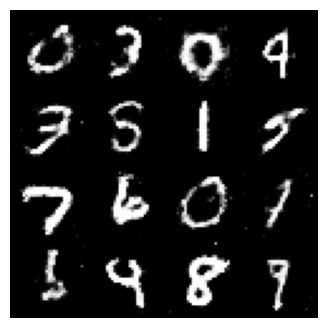

Epoch [43/50] Batch [0/937] D_loss: 1.1022 G_loss: 0.9815 D(real): 0.4833 D(fake): -0.4079
Epoch [43/50] Batch [100/937] D_loss: 1.1312 G_loss: 0.9298 D(real): 0.4271 D(fake): -0.3103
Epoch [43/50] Batch [200/937] D_loss: 1.1805 G_loss: 1.0548 D(real): 0.3538 D(fake): -0.5369
Epoch [43/50] Batch [300/937] D_loss: 1.1687 G_loss: 0.9003 D(real): 0.2349 D(fake): -0.3041
Epoch [43/50] Batch [400/937] D_loss: 1.3120 G_loss: 0.8797 D(real): -0.0846 D(fake): -0.2274
Epoch [43/50] Batch [500/937] D_loss: 1.1360 G_loss: 1.1242 D(real): 0.5016 D(fake): -0.6336
Epoch [43/50] Batch [600/937] D_loss: 1.2419 G_loss: 0.6411 D(real): -0.1060 D(fake): 0.2174
Epoch [43/50] Batch [700/937] D_loss: 1.2568 G_loss: 0.8936 D(real): 0.1997 D(fake): -0.2638
Epoch [43/50] Batch [800/937] D_loss: 1.1966 G_loss: 1.1292 D(real): 0.4857 D(fake): -0.6393
Epoch [43/50] Batch [900/937] D_loss: 1.1614 G_loss: 0.8067 D(real): 0.2386 D(fake): -0.1224

--- Generated samples at epoch 43 ---


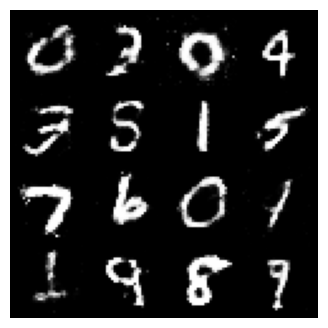

Epoch [44/50] Batch [0/937] D_loss: 1.1710 G_loss: 0.7971 D(real): 0.3357 D(fake): -0.1155
Epoch [44/50] Batch [100/937] D_loss: 1.0489 G_loss: 1.0002 D(real): 0.8845 D(fake): -0.4014
Epoch [44/50] Batch [200/937] D_loss: 1.1352 G_loss: 0.8885 D(real): 0.2149 D(fake): -0.2868
Epoch [44/50] Batch [300/937] D_loss: 1.2084 G_loss: 1.1220 D(real): 0.3044 D(fake): -0.5512
Epoch [44/50] Batch [400/937] D_loss: 1.1708 G_loss: 1.0361 D(real): 0.6916 D(fake): -0.4847
Epoch [44/50] Batch [500/937] D_loss: 1.2534 G_loss: 0.6452 D(real): -0.1045 D(fake): 0.2179
Epoch [44/50] Batch [600/937] D_loss: 1.0941 G_loss: 1.1110 D(real): 0.5769 D(fake): -0.6536
Epoch [44/50] Batch [700/937] D_loss: 1.2052 G_loss: 1.3450 D(real): 0.4432 D(fake): -0.9520
Epoch [44/50] Batch [800/937] D_loss: 1.1813 G_loss: 1.0034 D(real): 0.6785 D(fake): -0.4485
Epoch [44/50] Batch [900/937] D_loss: 1.2222 G_loss: 1.1841 D(real): 0.5337 D(fake): -0.7192

--- Generated samples at epoch 44 ---


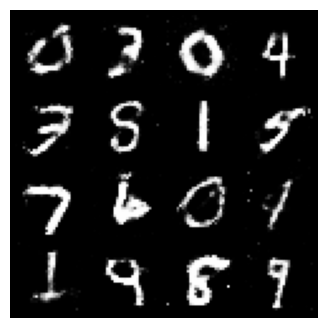

Epoch [45/50] Batch [0/937] D_loss: 1.3117 G_loss: 0.8600 D(real): -0.0054 D(fake): -0.1286
Epoch [45/50] Batch [100/937] D_loss: 1.2076 G_loss: 1.0110 D(real): 0.0055 D(fake): -0.4233
Epoch [45/50] Batch [200/937] D_loss: 1.2724 G_loss: 0.8162 D(real): -0.0695 D(fake): -0.1100
Epoch [45/50] Batch [300/937] D_loss: 1.2129 G_loss: 1.0556 D(real): 0.6180 D(fake): -0.5470
Epoch [45/50] Batch [400/937] D_loss: 1.2262 G_loss: 1.0057 D(real): 0.4442 D(fake): -0.4193
Epoch [45/50] Batch [500/937] D_loss: 1.1553 G_loss: 1.0923 D(real): 0.7981 D(fake): -0.6067
Epoch [45/50] Batch [600/937] D_loss: 1.1894 G_loss: 0.8737 D(real): 0.0554 D(fake): -0.1767
Epoch [45/50] Batch [700/937] D_loss: 1.2680 G_loss: 0.9446 D(real): 0.5855 D(fake): -0.3625
Epoch [45/50] Batch [800/937] D_loss: 1.1530 G_loss: 0.9250 D(real): 0.6098 D(fake): -0.2636
Epoch [45/50] Batch [900/937] D_loss: 1.1776 G_loss: 1.0120 D(real): 0.3980 D(fake): -0.4806

--- Generated samples at epoch 45 ---


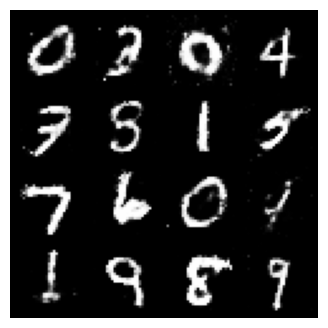

Epoch [46/50] Batch [0/937] D_loss: 1.2041 G_loss: 0.8432 D(real): 0.0200 D(fake): -0.2060
Epoch [46/50] Batch [100/937] D_loss: 1.2608 G_loss: 1.2019 D(real): 0.6441 D(fake): -0.7801
Epoch [46/50] Batch [200/937] D_loss: 1.1362 G_loss: 0.9308 D(real): 0.4717 D(fake): -0.3103
Epoch [46/50] Batch [300/937] D_loss: 1.2590 G_loss: 0.9544 D(real): 0.1198 D(fake): -0.3660
Epoch [46/50] Batch [400/937] D_loss: 1.2878 G_loss: 1.0767 D(real): -0.0168 D(fake): -0.5425
Epoch [46/50] Batch [500/937] D_loss: 1.1101 G_loss: 1.1412 D(real): 0.6044 D(fake): -0.6365
Epoch [46/50] Batch [600/937] D_loss: 1.1331 G_loss: 0.8328 D(real): 0.2061 D(fake): -0.1500
Epoch [46/50] Batch [700/937] D_loss: 1.1858 G_loss: 1.1166 D(real): 0.4694 D(fake): -0.6141
Epoch [46/50] Batch [800/937] D_loss: 1.2690 G_loss: 0.6253 D(real): -0.2356 D(fake): 0.2803
Epoch [46/50] Batch [900/937] D_loss: 1.2975 G_loss: 0.7293 D(real): -0.0551 D(fake): 0.0514

--- Generated samples at epoch 46 ---


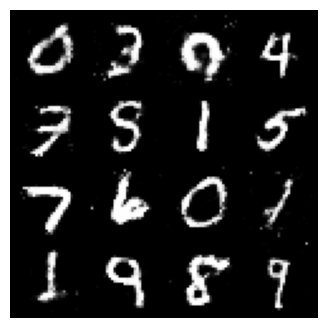

Epoch [47/50] Batch [0/937] D_loss: 1.1906 G_loss: 1.0620 D(real): 0.2943 D(fake): -0.5449
Epoch [47/50] Batch [100/937] D_loss: 1.2556 G_loss: 1.4445 D(real): 0.8097 D(fake): -1.1041
Epoch [47/50] Batch [200/937] D_loss: 1.1955 G_loss: 1.2393 D(real): 0.6764 D(fake): -0.8219
Epoch [47/50] Batch [300/937] D_loss: 1.1567 G_loss: 0.8781 D(real): 0.2466 D(fake): -0.2628
Epoch [47/50] Batch [400/937] D_loss: 1.2190 G_loss: 1.3283 D(real): 1.3073 D(fake): -0.9430
Epoch [47/50] Batch [500/937] D_loss: 1.2160 G_loss: 1.0445 D(real): 0.2953 D(fake): -0.5122
Epoch [47/50] Batch [600/937] D_loss: 1.1440 G_loss: 0.7427 D(real): 0.1984 D(fake): 0.0408
Epoch [47/50] Batch [700/937] D_loss: 1.3141 G_loss: 1.3746 D(real): 1.4054 D(fake): -1.0071
Epoch [47/50] Batch [800/937] D_loss: 1.1901 G_loss: 1.3348 D(real): 0.8508 D(fake): -0.9394
Epoch [47/50] Batch [900/937] D_loss: 1.2176 G_loss: 1.1293 D(real): 0.7146 D(fake): -0.6660

--- Generated samples at epoch 47 ---


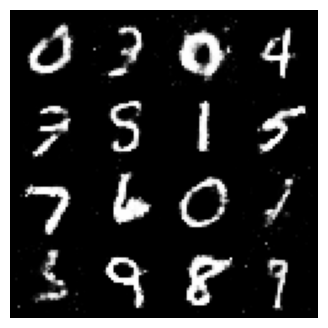

Epoch [48/50] Batch [0/937] D_loss: 1.1583 G_loss: 0.9530 D(real): 0.3091 D(fake): -0.3584
Epoch [48/50] Batch [100/937] D_loss: 1.1323 G_loss: 1.0088 D(real): 0.3972 D(fake): -0.4624
Epoch [48/50] Batch [200/937] D_loss: 1.1824 G_loss: 0.9569 D(real): 0.3467 D(fake): -0.3324
Epoch [48/50] Batch [300/937] D_loss: 1.3033 G_loss: 0.6478 D(real): -0.2289 D(fake): 0.2065
Epoch [48/50] Batch [400/937] D_loss: 1.2394 G_loss: 1.0584 D(real): 0.6794 D(fake): -0.5134
Epoch [48/50] Batch [500/937] D_loss: 1.1640 G_loss: 1.3875 D(real): 0.9488 D(fake): -1.0138
Epoch [48/50] Batch [600/937] D_loss: 1.2377 G_loss: 1.2798 D(real): 0.3959 D(fake): -0.8613
Epoch [48/50] Batch [700/937] D_loss: 1.1269 G_loss: 0.8867 D(real): 0.5937 D(fake): -0.2288
Epoch [48/50] Batch [800/937] D_loss: 1.2452 G_loss: 0.9385 D(real): 0.4763 D(fake): -0.3255
Epoch [48/50] Batch [900/937] D_loss: 1.3746 G_loss: 1.0331 D(real): 0.5268 D(fake): -0.4623

--- Generated samples at epoch 48 ---


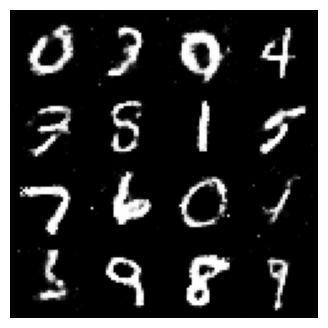

Epoch [49/50] Batch [0/937] D_loss: 1.2545 G_loss: 0.9925 D(real): -0.0823 D(fake): -0.4479
Epoch [49/50] Batch [100/937] D_loss: 1.2283 G_loss: 0.6757 D(real): -0.2512 D(fake): 0.2323
Epoch [49/50] Batch [200/937] D_loss: 1.1878 G_loss: 0.8018 D(real): -0.0608 D(fake): -0.0947
Epoch [49/50] Batch [300/937] D_loss: 1.1470 G_loss: 0.9629 D(real): 0.4626 D(fake): -0.3835
Epoch [49/50] Batch [400/937] D_loss: 1.1441 G_loss: 1.0295 D(real): 0.4179 D(fake): -0.4950
Epoch [49/50] Batch [500/937] D_loss: 1.2208 G_loss: 0.6962 D(real): -0.0773 D(fake): 0.1245
Epoch [49/50] Batch [600/937] D_loss: 1.1985 G_loss: 0.8417 D(real): 0.4448 D(fake): -0.1751
Epoch [49/50] Batch [700/937] D_loss: 1.3303 G_loss: 0.6276 D(real): -0.2114 D(fake): 0.2663
Epoch [49/50] Batch [800/937] D_loss: 1.3381 G_loss: 0.8529 D(real): -0.2230 D(fake): -0.1955
Epoch [49/50] Batch [900/937] D_loss: 1.2044 G_loss: 0.9191 D(real): 0.4293 D(fake): -0.2729

--- Generated samples at epoch 49 ---


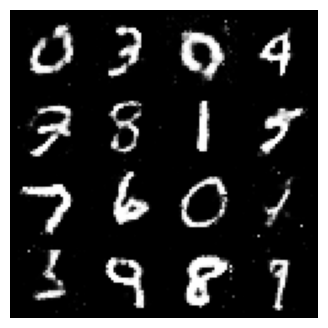

Epoch [50/50] Batch [0/937] D_loss: 1.3659 G_loss: 1.2161 D(real): 1.1241 D(fake): -0.7544
Epoch [50/50] Batch [100/937] D_loss: 1.2280 G_loss: 0.8981 D(real): 0.5160 D(fake): -0.2505
Epoch [50/50] Batch [200/937] D_loss: 1.1756 G_loss: 1.2806 D(real): 0.8913 D(fake): -0.8752
Epoch [50/50] Batch [300/937] D_loss: 1.1880 G_loss: 0.7830 D(real): -0.0403 D(fake): -0.0623
Epoch [50/50] Batch [400/937] D_loss: 1.1207 G_loss: 0.8944 D(real): 0.3027 D(fake): -0.2381
Epoch [50/50] Batch [500/937] D_loss: 1.1187 G_loss: 1.0202 D(real): 0.7046 D(fake): -0.4745
Epoch [50/50] Batch [600/937] D_loss: 1.1329 G_loss: 0.9229 D(real): 0.6963 D(fake): -0.2552
Epoch [50/50] Batch [700/937] D_loss: 1.2434 G_loss: 1.2468 D(real): 0.8526 D(fake): -0.8159
Epoch [50/50] Batch [800/937] D_loss: 1.1494 G_loss: 1.2885 D(real): 0.6877 D(fake): -0.8688
Epoch [50/50] Batch [900/937] D_loss: 1.1226 G_loss: 1.0507 D(real): 0.4419 D(fake): -0.5442

--- Generated samples at epoch 50 ---


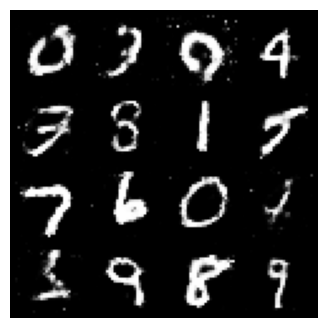

In [155]:
fixed_z = randn(16, latent_dim, device=device)

# Track losses
d_losses = []
g_losses = []

# ---------------------------------------
# Training Loop
# ---------------------------------------
for epoch in range(epochs):

    for batch_i, (real_images, _) in enumerate(loader):

        real_images = real_images.view(batch_size, -1).to(device)

        # ---------------------------
        # Train D
        # ---------------------------
        z = randn(batch_size, latent_dim, device=device)
        fake_images = G(z).detach()

        real_logits = D(real_images)
        fake_logits = D(fake_images)

        real_labels = ones(batch_size, 1, device=device)
        fake_labels = zeros(batch_size, 1, device=device)

        loss_real = loss_fn(real_logits, real_labels)
        loss_fake = loss_fn(fake_logits, fake_labels)
        loss_D = loss_real + loss_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ---------------------------
        # Train G
        # ---------------------------
        z = randn(batch_size, latent_dim, device=device)
        fake_images = G(z)
        fake_logits = D(fake_images)

        real_labels = ones(batch_size, 1, device=device)
        loss_G = loss_fn(fake_logits, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # Store losses
        d_losses.append(loss_D.item())
        g_losses.append(loss_G.item())

        # Logging
        if batch_i % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{epochs}] "
                f"Batch [{batch_i}/{len(loader)}] "
                f"D_loss: {loss_D.item():.4f} "
                f"G_loss: {loss_G.item():.4f} "
                f"D(real): {real_logits.mean().item():.4f} "
                f"D(fake): {fake_logits.mean().item():.4f}"
            )

    # ---------------------------------------
    # Generate grid every epoch
    # ---------------------------------------
    with no_grad():
        samples = G(fixed_z).detach().cpu()
        print(f"\n--- Generated samples at epoch {epoch+1} ---")
        show_grid(samples)

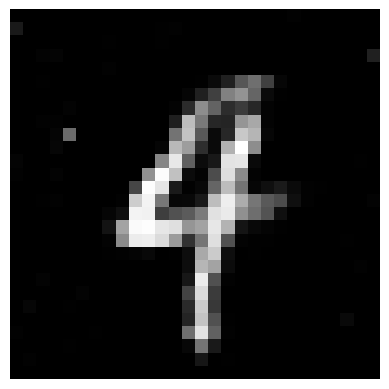

Generator(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

In [156]:
G.eval()

with no_grad():
    z = randn(1, latent_dim, device=device)
    fake_image = G(z).cpu()

fake_image = fake_image.view(28, 28)
fake_image = (fake_image + 1) / 2

plt.imshow(fake_image, cmap="gray")
plt.axis("off")
plt.show()

G.train()


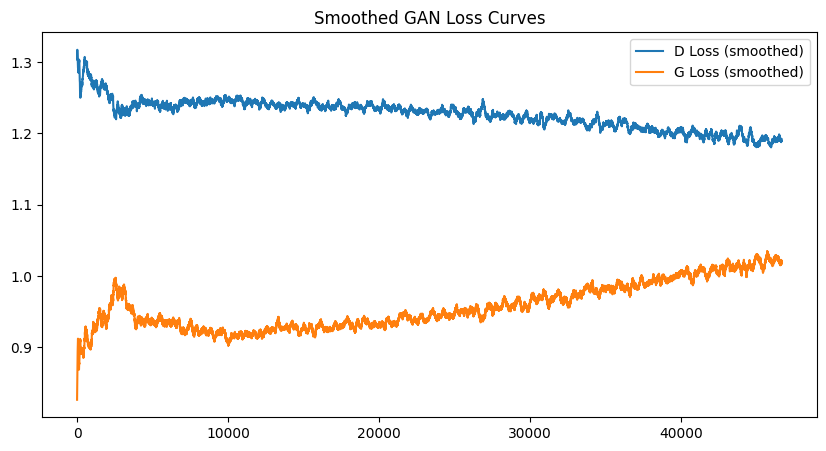

In [158]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10,5))
plt.plot(moving_average(d_losses, 200), label="D Loss (smoothed)")
plt.plot(moving_average(g_losses, 200), label="G Loss (smoothed)")
plt.legend()
plt.title("Smoothed GAN Loss Curves")
plt.show()
